In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import *
from utils import *

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [2]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [3]:
# as given in the paper
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1 # paper: 0.1
NUM_SCALES = 9
SCALING_FACTOR = 4/3
INITIAL_KERNEL_COUNT = 32
INCREASE_KERNEL_COUNT_EVERY = 4 # SCALES
NOISE_BASE_STD = 0.1
FIRST_SCALE_NOISE_STD = 1.0
START_SIZE = (250, 250)
SCALING_MODE = 'bicubic'


PRINT_EVERY = 25
DEVICE = 'cuda'
SEED = 796

conv2d_initializer = None
batch_norm_initializer = None

Dataset already downloaded
BSDS300/images/train/109034.jpg


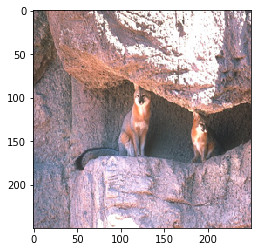

In [4]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize(START_SIZE, Image.BICUBIC))
plt.imshow(orig_img_uint)
print(EXAMPLE_IMG_PATH)

In [5]:
# seed stuff
np.random.seed(SEED)
torch.manual_seed(SEED)

# create the scaled images
original_image = np_image_to_normed_tensor(orig_img_uint).to(DEVICE)
scaled_original_images, exact_scale_sizes = create_scale_pyramid(original_image, 1/SCALING_FACTOR, NUM_SCALES, SCALING_MODE)
scaled_original_images, exact_scale_sizes = scaled_original_images[::-1], exact_scale_sizes[::-1]  # reverse since we start from coarsest
coarsest_exact_size = exact_scale_sizes[0]
print(exact_scale_sizes)
print([q.shape for q in scaled_original_images])

# initialize the constant noise used in reconstruction
z_rec_coarsest = FIRST_SCALE_NOISE_STD * torch.randn_like(scaled_original_images[0], device=DEVICE)
z_rec = [z_rec_coarsest] # a zero tensor is appended after each scale

# constant zero input for the coarsest scale during training
coarsest_zero_input = torch.zeros_like(z_rec_coarsest)


[(25.028228759765625, 25.028228759765625), (33.3709716796875, 33.3709716796875), (44.49462890625, 44.49462890625), (59.326171875, 59.326171875), (79.1015625, 79.1015625), (105.46875, 105.46875), (140.625, 140.625), (187.5, 187.5), (250.0, 250.0)]
[torch.Size([1, 3, 33, 33]), torch.Size([1, 3, 44, 44]), torch.Size([1, 3, 59, 59]), torch.Size([1, 3, 79, 79]), torch.Size([1, 3, 105, 105]), torch.Size([1, 3, 141, 141]), torch.Size([1, 3, 188, 188]), torch.Size([1, 3, 250, 250]), torch.Size([1, 3, 250, 250])]


/home/deniz/anaconda3/envs/torchenv/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


****************************
Scale 0
RMSE: 1.00
Norm sums:
Gen-0 norm: 37.86
Critic norm: 37.46
Start


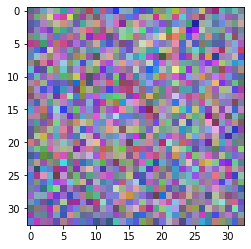

Step: 0
Generator adv: 0.182, rec: 0.212
Critic fake: -0.155 real: 0.068 grad: 0.215


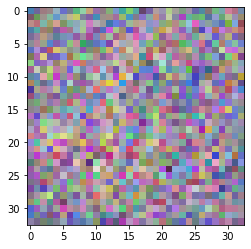

Step: 25
Generator adv: 0.397, rec: 0.008
Critic fake: -0.354 real: -0.146 grad: 2.232
Steps per second: 9.90


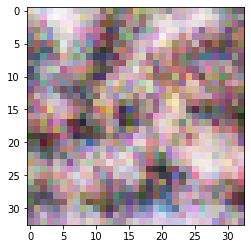

Step: 50
Generator adv: 0.555, rec: 0.003
Critic fake: -0.584 real: 0.051 grad: 1.789
Steps per second: 10.21


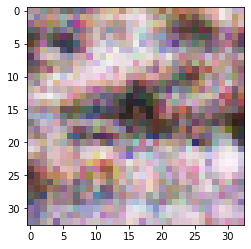

Step: 75
Generator adv: 0.872, rec: 0.004
Critic fake: -0.855 real: 0.268 grad: 2.311
Steps per second: 10.16


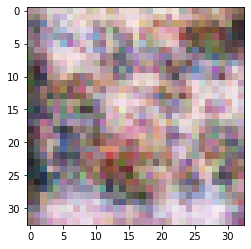

Step: 100
Generator adv: 0.855, rec: 0.004
Critic fake: -0.855 real: 0.240 grad: 1.941
Steps per second: 10.95


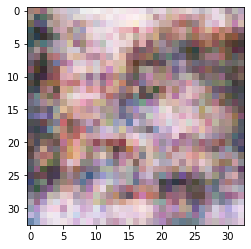

Step: 125
Generator adv: 1.281, rec: 0.002
Critic fake: -1.219 real: 0.342 grad: 7.133
Steps per second: 9.67


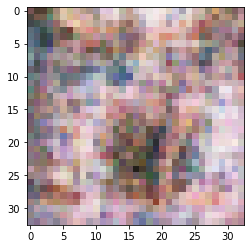

Step: 150
Generator adv: 1.262, rec: 0.002
Critic fake: -1.166 real: 0.327 grad: 1.478
Steps per second: 9.65


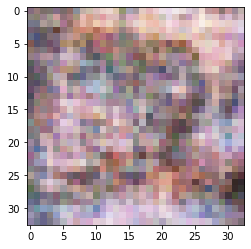

Step: 175
Generator adv: 1.286, rec: 0.004
Critic fake: -1.257 real: 0.565 grad: 2.331
Steps per second: 10.21


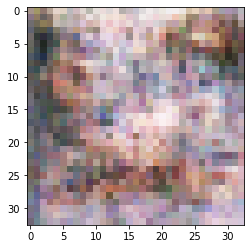

Step: 200
Generator adv: 1.033, rec: 0.004
Critic fake: -1.044 real: 0.163 grad: 5.459
Steps per second: 11.39


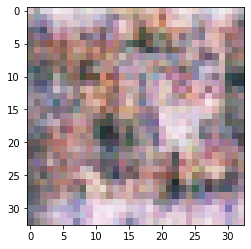

Step: 225
Generator adv: 0.935, rec: 0.003
Critic fake: -1.096 real: 0.109 grad: 2.859
Steps per second: 10.45


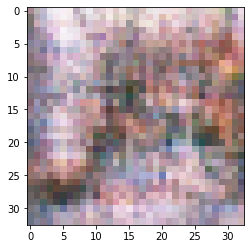

Step: 250
Generator adv: 1.237, rec: 0.003
Critic fake: -1.501 real: 0.490 grad: 7.221
Steps per second: 10.55


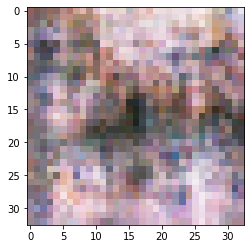

Step: 275
Generator adv: 1.321, rec: 0.004
Critic fake: -1.332 real: 0.378 grad: 1.366
Steps per second: 9.74


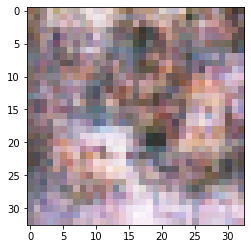

Step: 300
Generator adv: 1.359, rec: 0.003
Critic fake: -1.358 real: 0.420 grad: 3.395
Steps per second: 9.60


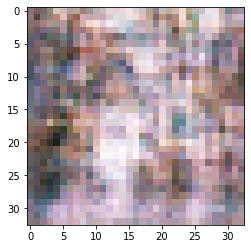

Step: 325
Generator adv: 1.113, rec: 0.003
Critic fake: -1.070 real: 0.204 grad: 2.101
Steps per second: 9.52


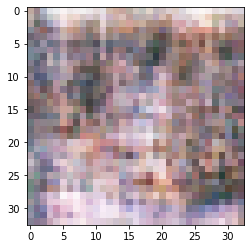

Step: 350
Generator adv: 1.063, rec: 0.003
Critic fake: -1.085 real: 0.137 grad: 4.210
Steps per second: 9.50


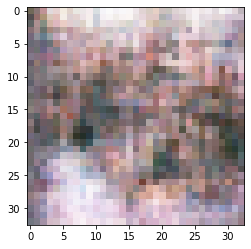

Step: 375
Generator adv: 1.335, rec: 0.003
Critic fake: -1.454 real: 0.510 grad: 5.138
Steps per second: 9.77


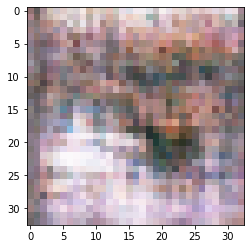

Step: 400
Generator adv: 1.001, rec: 0.002
Critic fake: -1.122 real: 0.154 grad: 1.900
Steps per second: 8.79


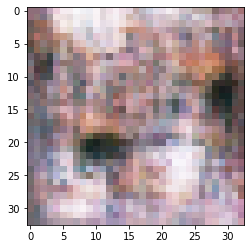

Step: 425
Generator adv: 1.281, rec: 0.003
Critic fake: -1.253 real: 0.283 grad: 3.367
Steps per second: 8.72


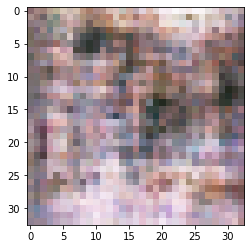

Step: 450
Generator adv: 1.252, rec: 0.004
Critic fake: -1.296 real: 0.273 grad: 2.662
Steps per second: 10.12


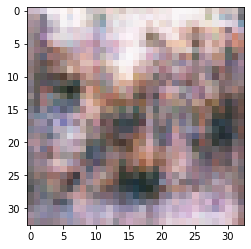

Step: 475
Generator adv: 1.265, rec: 0.003
Critic fake: -1.309 real: 0.264 grad: 2.772
Steps per second: 9.98


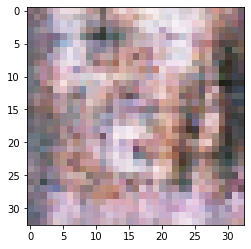

Step: 500
Generator adv: 1.111, rec: 0.002
Critic fake: -1.118 real: 0.024 grad: 3.397
Steps per second: 9.55


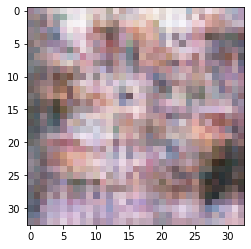

Step: 525
Generator adv: 1.135, rec: 0.002
Critic fake: -1.027 real: -0.020 grad: 5.407
Steps per second: 9.56


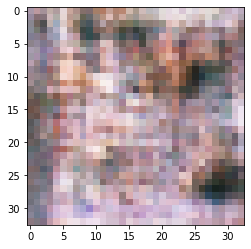

KeyboardInterrupt: 

In [6]:

# loop values
kernel_count = INITIAL_KERNEL_COUNT
generators, critics, noise_samplers = [], [], []
gen_losses, crit_losses = [], []
rmse = 1 # initial noise multiplier
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))


  # get the original image at the necessary scale for reconstruction
  scale_orig_img = scaled_original_images[scale_index]

  # if a previous generator exists, use RMSE to determine
  # the standard deviation of the input noise
  if scale_index > 0:
    reconstruction = generator(coarsest_zero_input, coarsest_exact_size, z_rec)
    scaled_reconstruction = exact_interpolate(reconstruction, exact_scale_sizes[scale_index-1], SCALING_FACTOR, SCALING_MODE)
    rmse = F.mse_loss(scaled_reconstruction, scale_orig_img).item()

  # create the noise sampler based on the RMSE
  # BUG: same noise_sampler is used for every scale, oof!
  scale_noise_std = FIRST_SCALE_NOISE_STD if scale_index == 0 else rmse * NOISE_BASE_STD
  scale_noise_sampler = lambda x: scale_noise_std * torch.randn_like(x, device=DEVICE)
  noise_samplers.append(scale_noise_sampler)
  print('RMSE: {:.2f}'.format(rmse))

  # renew architectures if it is time to change kernel sizes
  architecture_changed = False
  if scale_index != 0 and scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    kernel_count *= 2
    architecture_changed = True

  ## initialize the generator
  # create a generator for this specific scale and initialize it
  scale_generator = SGNet(output_channels=3, kernel_count=kernel_count, final_activation=nn.Tanh(), 
                          conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE)
  init_net(scale_generator, generators, architecture_changed)
  # create a single generator view from the stack of generators
  generator = MultiScaleSGNetView(generators, SCALING_FACTOR, noise_samplers)

  ## initialize the critic (discriminator)
  # the authors recommend initializing the discriminator using the weights of
  # the previous one unless the number of kernels is changed
  critic = SGNet(output_channels=1, kernel_count=kernel_count, final_activation=None, 
                 conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE) # patch critic
  init_net(critic, critics, architecture_changed)
  
  # weight of gen0 to ensure it is not trained
  print('Norm sums:')
  for i, gen in enumerate(generators):
    wbs = get_weights_and_biases(gen)
    norm = torch.tensor([torch.norm(x) for x in wbs]).sum().item()
    print('Gen-{} norm: {:.2f}'.format(i, norm))
  print('Critic norm: {:.2f}'.format(torch.tensor([torch.norm(x) for x in get_weights_and_biases(critic)]).sum().item()))

  # re-create the optimizers and schedulers
  gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  gen_sched = torch.optim.lr_scheduler.StepLR(gen_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  crit_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  crit_sched = torch.optim.lr_scheduler.StepLR(crit_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  # add a zero tensor to the reconstruction noise list
  # since it is defined as [z*, 0, 0, 0...] for some z*
  if scale_index != 0:
    z_rec.append(torch.zeros_like(scale_orig_img))

  # perform training

  print('Start')
  fake_img = generator(coarsest_zero_input, coarsest_exact_size)
  plt.imshow(normed_tensor_to_np_image(fake_img))
  plt.show()

  for step in range(NUM_ITERS):

    for _ in range(DIS_STEP_PER_ITER):
      crit_optimizer.zero_grad()


      # adversarial loss
      # take a sample from the line between the real and generated images
      # for use in the gradient penalty (Impr. Training of WGANs)

      # another thing that is not very clear is the WGAN-GP loss in this context.
      # In the case of a scalar discr. output, what should be done is simply
      # norm the gradient (image-shaped) across the channel axis, and take 
      # the mean across all pixels.
      # In this case, the output of the critic (discr) is an image (PatchGAN).
      # If we take its mean to obtain a scalar and then apply the same approach
      # as the scalar output discr., it seems to supress the penalty twice 
      # (as if the mean was applied twice). Instead, taking the sum of the
      # output allows us to apply the mean only once, which we believe is the
      # proper normalization.

      epsilon = np.random.uniform(0, 1)
      fake_img = generator(coarsest_zero_input, coarsest_exact_size)
      grad_sample = epsilon * scale_orig_img + (1 - epsilon) * fake_img
      f_grad_sample = critic(grad_sample).sum()
      grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)
      grad_loss = ((torch.norm(grad, 2, dim=1) - 1)**2).mean() # mean over batch

      # calculate the f losses and sum up
      fake_loss = critic(fake_img).mean()
      real_loss = -critic(scale_orig_img).mean()
      crit_loss =  fake_loss + real_loss + GP_WEIGHT * grad_loss # TODO: are signs of fake and real loss correct? 
      
      # optimize
      crit_loss.backward()
      crit_optimizer.step()
      crit_sched.step()
      crit_losses.append(crit_loss.item())

    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      # always provide zero input to the coarsest scale
      # the model handles noise sampling on its own
      fake_img = generator(coarsest_zero_input, coarsest_exact_size)

      # adversarial loss
      adv_loss = -critic(fake_img).mean()

      # reconstruction loss
      rec_img = generator(coarsest_zero_input, coarsest_exact_size, z_rec)
      rec_loss = F.mse_loss(scale_orig_img, rec_img)

      # total loss & optimization
      gen_loss = adv_loss + REC_ALPHA * rec_loss
      gen_loss.backward()
      gen_optimizer.step()
      gen_sched.step()
      gen_losses.append(gen_loss.item())

    if step % PRINT_EVERY == 0:
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.item(), rec_loss.item()))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.item(), real_loss.item(), grad_loss.item()))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
      plt.imshow(normed_tensor_to_np_image(fake_img))
      plt.show()
      last_print = time()

  print('Reconstruction:')
  plt.imshow(normed_tensor_to_np_image(generator(generator_zero_input, z_rec)))
  plt.show()


In [ ]:
plt.plot(crit_losses)
plt.show()

In [ ]:
!nvidia-smi

In [ ]:
print(SGNet(output_channels=1, kernel_count=kernel_count, final_activation=nn.Identity()).to(DEVICE)(torch.ones(1, 3, 5, 5).cuda()))